# Universal Atrial Coordinates - Left Atrium

## Import stuff

In [1]:
import os,sys
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pyvista as pv

sys.path.append('../openep-py')
import openep

sys.path.append('/mnt/d/vgmar/Documents/GitHub/USI/model-analyses/aux-functions')
import IgbHandling as igb
import quick_visualization as qv


%matplotlib qt

from openep.mesh.mesh_routines import (
    _create_trimesh,
    get_free_boundaries,
    calculate_mesh_volume,
    calculate_field_area,
    calculate_vertex_distance,
    calculate_vertex_path,
)

from openep.draw import draw_map,draw_free_boundaries

def freeBoundaryPoints(FF,tr):
    return  tr[FF[:,0],:]

%load_ext autoreload
%autoreload 2

## Load the original data in openEP format

To adjust to openEP, one can use the Matlab functions or try to create a "fake" case.

The following cells get the free boundaries of this geometry (veins must be open) and get corresponding mesh indices for them.

The user has to adjust the names of each boundary so that the correct indexes are selected

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-vgmarques'


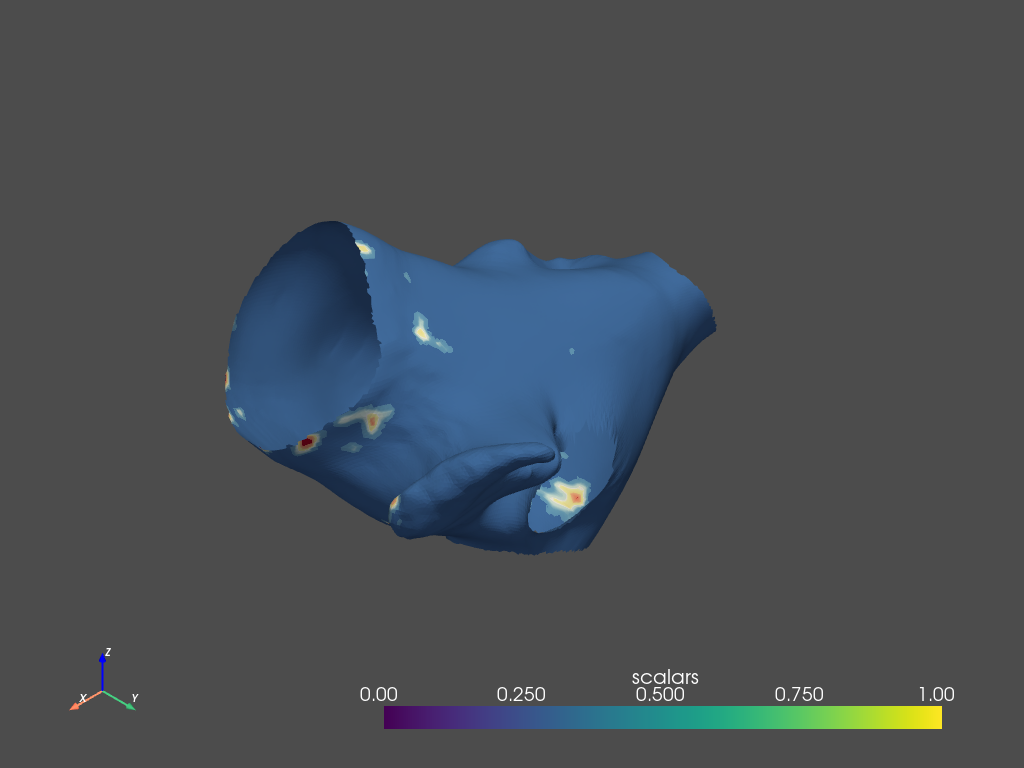

In [2]:
# Load file

# LACode = 1
# filepath = '/mnt/d/vgmar/patient_data/Fibre_Files/LA_Endo/%d/'%LACode
# expName = 'LA_'+str(LACode)
# inFile = 'Labelled_%d_%d'%(LACode,LACode)


# filepath = '/mnt/d/vgmar/Documents/BitBucket/UAC/UAC_py/carp'
# inFile = 'model24_laepi.vtk'
# expName = 'Model_LA_epi'


filepath = '/mnt/d/vgmar/Documents/BitBucket/UAC/UAC_py/carp/ADAS03B_LA'
inFile = 'ADAS03B_LA_og.vtk'
expName = 'ADAS03B_LA'

############### Choose the method to import data

##### Load from .pts and .elem
# case = openep.load_opencarp(os.path.join(filepath,inFile+'.pts'),
#                             os.path.join(filepath,inFile+'.elem'),
#                             expName)
# mesh = case.create_mesh()

#### Load from vtk (Saved after the Paraview commands Clip > ExtractSurface > Triangulate > Save Data)
mesh = pv.PolyData(os.path.join(filepath,inFile))
# mesh.points = mesh.points*1e3


####
mesh.plot(jupyter_backend='static')

In [3]:
removeInds = np.isin(np.arange(mesh.n_points),mesh.faces)

faces = mesh.faces.reshape(-1,4)[:,1:]
removeInds = ~np.isin(np.arange(mesh.n_points),faces.flatten())


mesh,ridx = mesh.remove_points(removeInds)
print(mesh.n_points)
# tmpmesh.plot(jupyter_backend='static')

39750


In [4]:
# getAnatomicalStructures
FB = get_free_boundaries(mesh)
FF = FB.separate_boundaries()
FF_size = FB.n_points_per_boundary

tr = {}
for i in range(len(FF)):
    # % get the points of this boundary
    coords = freeBoundaryPoints(FF[i], mesh.points)
    
    # % find the centre of the points
    centre = np.mean(coords, axis=0)
    
    # % create a triRep of the boundary
    X = np.vstack([centre,coords])# [centre; coords];
    numpts = len(X)
    A = np.zeros(numpts-1,int)
    B = np.arange(1,numpts)
    C = np.hstack([np.arange(2,numpts),[2]])
    TRI = np.vstack([A,B,C]).T
    tr[i] = [TRI, X[:,0], X[:,1], X[:,2]]


In [5]:
# Get the actual indices for the free boundaries

for i,boundary in enumerate(FF):
    boundary = boundary[:,0]
    points = FB.points[boundary,:]

    boundaryPointIndices = [np.where((A==mesh.points[:,0])&(B==mesh.points[:,1])&(C==mesh.points[:,2]))[0][0] for A,B,C in points]
    FF[i] = np.asarray(boundaryPointIndices)

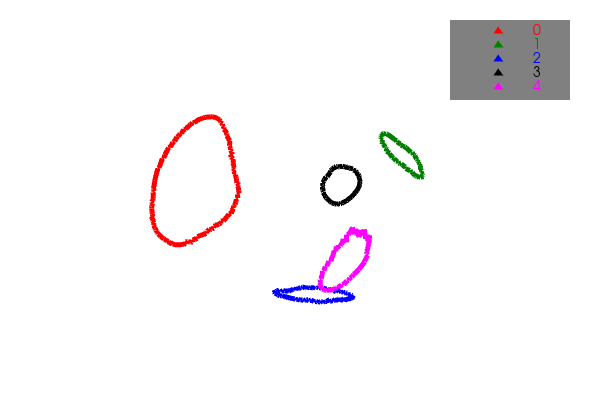

In [6]:
COLOURS = ['r','g','b','k','m','c','y','orange','darkgrey']

P = draw_free_boundaries(FB,colour = COLOURS)
P.background_color = "white"
P.add_legend([['0',COLOURS[0]],['1',COLOURS[1]],['2',COLOURS[2]],['3',COLOURS[3]],['4',COLOURS[4]]])
P.show(jupyter_backend='static',window_size=[600,400])

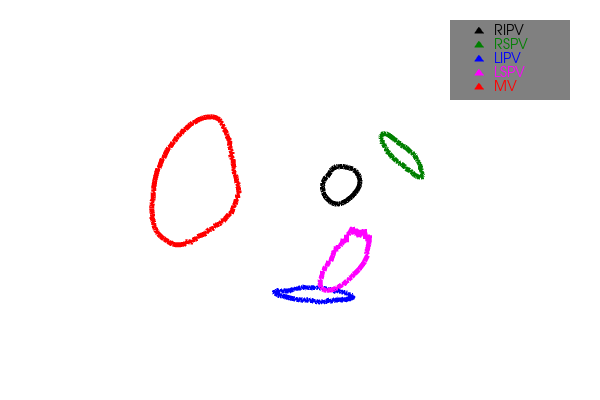

In [7]:
# Adjust the names for each boundary
boundaryNames = {'RIPV':3,
                 'RSPV':1,
                 'LIPV':2,
                 'LSPV':4,
                 'MV':0}
P = draw_free_boundaries(FB,colour = COLOURS)
P.background_color = "white"
P.add_legend([[name,COLOURS[c]] for name,c in boundaryNames.items()])
P.show(jupyter_backend='static',window_size=[600,400])


In [8]:
ripvIndices = FF[boundaryNames['RIPV']]
rspvIndices = FF[boundaryNames['RSPV']]

lipvIndices = FF[boundaryNames['LIPV']]
lspvIndices = FF[boundaryNames['LSPV']]

mvIndices = FF[boundaryNames['MV']]

## Selection of landmarks

The following landmarks have to be selected:

- RSPV-RA Junction close to roof
- LSPV-RA Junction close to roof
- Anterior edge of fossa ovalis
- RSPV-RA Junction close to MV (septum)
- LSPV-RA Junction close to MV (lateral)

In the original paper, only 3 first points are required
In order to avoid all the automatic bits that may take a while to program, I am selecting points in both sides of the veins, and a MV point that will go through the FO.


Use Paraview for this if using WSL and if you value your sanity

In [9]:
# pointIndices = []
# def callback(x,y,list = pointIndices): 
#     print(y)
#     return list.append(y)
    
# plotter = draw_map(mesh,np.zeros(mesh.n_cells),free_boundaries = False)
# plotter = draw_free_boundaries(FB,plotter=plotter,colour = COLOURS)
# plotter.enable_point_picking(pickable_window=False,
#                              left_clicking=False,
#                              use_mesh =True,
#                              callback = callback) 
# # # plotter.window_size = [400, 400]
# plotter.add_legend([[name,COLOURS[c]] for name,c in boundaryNames.items()])
# plotter.background_color = "white"
# plotter.show()

In [21]:
# LA_01
# pointIndices = {'RSPV-LA':45131,
#                 'LSPV-LA':23661,
#                 'FO':41729,
#                 'RSPV-MV':6535,
#                 'LSPV-MV':27063,
#                 'LAA-Post':3108}

# # LA Model Endo
# pointIndices = {'RSPV-LA': 4370,
#                 'LSPV-LA': 3265,
#                 'FO': 1034,# or 1034?
#                 'RSPV-MV': 4386,
#                 'LSPV-MV': 1995,
#                 'LAA-Post': 3766}

# LA Model Epi
# pointIndices = {'RSPV-LA': 3916,
#                 'LSPV-LA': 3112,
#                 'FO': 2335,# or 1034?
#                 'RSPV-MV': 3931,
#                 'LSPV-MV': 1361,
#                 'LAA-Post': 2017}

# # # Adas Patient 02
# pointIndices = {'RSPV-LA':28905,
#                 'LSPV-LA':24161,
#                 'FO':31839,
#                 'RSPV-MV':28332,
#                 'LSPV-MV':18837,
#                 'LAA-Post':17402}
# # Adas Patient 02
# pointIndices = {'RSPV-LA':889,
#                 'LSPV-LA':37072,
#                 'FO':28729,
#                 'RSPV-MV':665,
#                 'LSPV-MV':1072,
#                 'LAA-Post':24392}

# Adas Patient 03B
pointIndices = {'RSPV-LA':35780,
                'LSPV-LA':35111,
                'FO':27190,
                'RSPV-MV':25506,
                'LSPV-MV':152,
                'LAA-Post':22151}

In [22]:
# Fix for possible missing points
if np.sum(removeInds)>0:
    for key,value in pointIndices.items():
        pointIndices[key] = np.where(ridx==value)[0][0]
pointIndices

{'RSPV-LA': 35780,
 'LSPV-LA': 35111,
 'FO': 27190,
 'RSPV-MV': 25506,
 'LSPV-MV': 152,
 'LAA-Post': 22151}

In [23]:
#Define MV points
# Septal: closest to FO

dists = np.linalg.norm(mesh.points[mvIndices]-mesh.points[pointIndices['FO']],axis=1)
pointIndices['MV-Sept'] = mvIndices[np.where(dists==np.nanmin(dists))[0][0]]

#Lateral: closest to LSPV-Mv point
dists = np.linalg.norm(mesh.points[mvIndices]-mesh.points[pointIndices['LAA-Post']],axis=1)
pointIndices['MV-Lat'] = mvIndices[np.where(dists==np.nanmin(dists))[0][0]]

## Create paths between the landmarks

The boundaries are:

- $\alpha_{LA}$ - Lateral-Septal coordinate:
    - Lower boundary = RSPV-FO-MV
    - Upper boundary = LSPV-Anterior LAA - MV
- $\beta_{LA}$ - postero-anterior coordinate:
    - Lower boundary = MV
    - Upper boundary = Roof+Posterior RSPV + Posterior LSPV

In [24]:
# pointIndices = ringPointIndex

Paths = {'RSPV-FO':['RSPV-MV','FO'],
         'FO-MV':['FO','MV-Sept'],
         'LSPV-LAA':['LSPV-MV','LAA-Post'],
         'LAA-MV':['LAA-Post','MV-Lat'],
         'RSPV-A':['RSPV-MV','RSPV-LA'],
         'LSPV-A':['LSPV-LA','LSPV-MV'],
         'Roof':['RSPV-LA','LSPV-LA']}

for pathName,pathComponents in Paths.items():
    path = calculate_vertex_path(mesh,pointIndices[pathComponents[0]],pointIndices[pathComponents[1]])
    Paths[pathName] = path

Paths['Septal'] = np.hstack([Paths['RSPV-FO'],Paths['FO-MV'][1:]])
Paths['Lateral'] = np.hstack([Paths['LSPV-LAA'],Paths['LAA-MV'][1:]])

# P = pv.Plotter()
# P.add_mesh(mesh)
# for i,path in enumerate(Paths.values()):
#     P.add_lines(mesh.points[path],COLOURS[i])
# P.show()#jupyter_backend='static')

In [25]:
# Define RSPV and LSPV junction rings: The rest of the vein is not the boundary

# RSPV

# veinPoints = mesh.points[ivcIndices,:]
# V1 = mesh.points[pointIndices['IVC-RA']]-np.mean(veinPoints,axis=0)
# V2 = mesh.points[pointIndices['IVC-TV']]-np.mean(veinPoints,axis=0)
meanExtremes = np.mean(mesh.points[[pointIndices['RSPV-LA'],pointIndices['RSPV-MV']]],axis=0)

# n = np.cross(V2,V1)
n = mesh.points[Paths['RSPV-A'][len(Paths['RSPV-A'])//2]]-meanExtremes
n = n/np.linalg.norm(n)

clippedMesh = mesh.clip(n,origin =meanExtremes)


seed = clippedMesh.find_closest_point(mesh.points[pointIndices['RSPV-MV']])
target = clippedMesh.find_closest_point(mesh.points[pointIndices['RSPV-LA']])

pathA = calculate_vertex_path(clippedMesh,seed,target)
Paths['RSPV-B'] = [mesh.find_closest_point(clippedMesh.points[ind]) for ind in pathA]

# #Fill gaps
pathA = calculate_vertex_path(mesh,pointIndices['RSPV-MV'],Paths['RSPV-B'][0])
pathB = calculate_vertex_path(mesh,Paths['RSPV-B'][-1],pointIndices['RSPV-LA'])

Paths['RSPV-B'] = np.hstack([pathA,Paths['RSPV-B'],pathB])

# LSPV

# veinPoints = mesh.points[svcIndices,:]
# V1 = mesh.points[pointIndices['SVC-RA']]-np.mean(veinPoints,axis=0)
# V2 = mesh.points[pointIndices['SVC-TV']]-np.mean(veinPoints,axis=0)
meanExtremes = np.mean(mesh.points[[pointIndices['LSPV-LA'],pointIndices['LSPV-MV']]],axis=0)

# n = np.cross(V2,V1)
n = mesh.points[Paths['LSPV-A'][len(Paths['LSPV-A'])//2]]-meanExtremes
n = n/np.linalg.norm(n)

clippedMesh = mesh.clip(n,origin =meanExtremes)

seed = clippedMesh.find_closest_point(mesh.points[pointIndices['LSPV-LA']])
target = clippedMesh.find_closest_point(mesh.points[pointIndices['LSPV-MV']])

pathA = calculate_vertex_path(clippedMesh,seed,target)
Paths['LSPV-B'] = [mesh.find_closest_point(clippedMesh.points[ind]) for ind in pathA]

#Fill gaps
pathA = calculate_vertex_path(mesh,pointIndices['LSPV-LA'],Paths['LSPV-B'][0])
pathB = calculate_vertex_path(mesh,Paths['LSPV-B'][-1],pointIndices['LSPV-MV'])

Paths['LSPV-B'] = np.hstack([pathA,Paths['LSPV-B'],pathB])

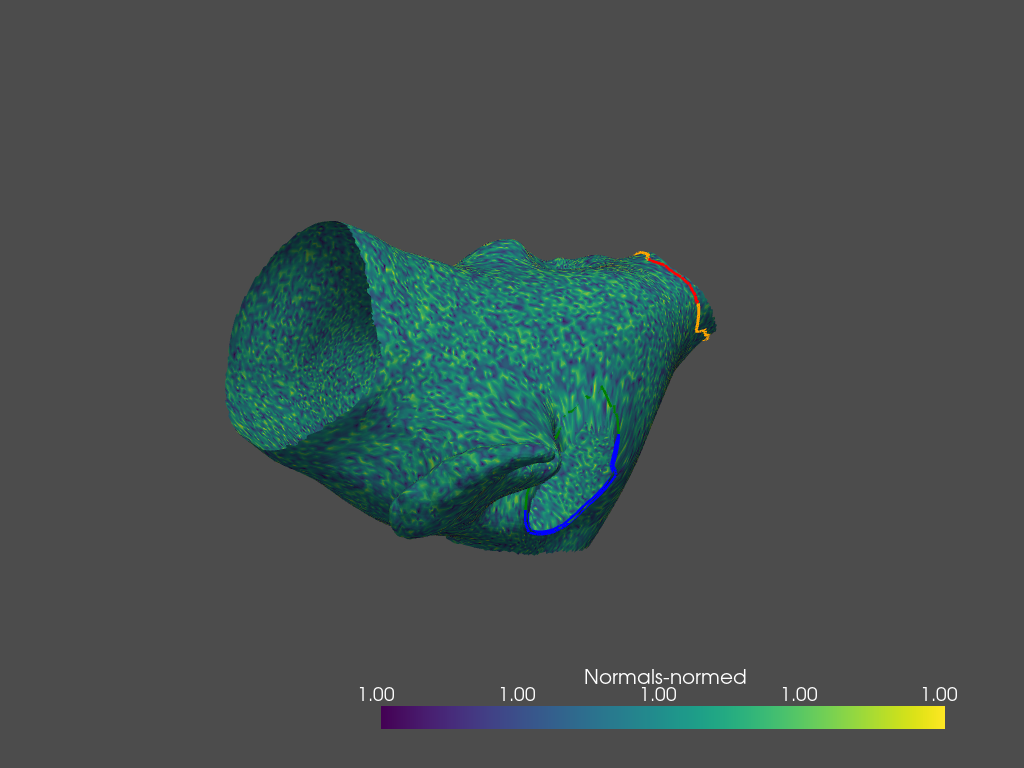

In [26]:
# Check to see if the boundaries are correct
P = pv.Plotter()

P.add_lines(mesh.points[Paths['RSPV-A']],'r')
P.add_lines(mesh.points[Paths['RSPV-B']],'orange')
P.add_lines(mesh.points[Paths['LSPV-A']],'b')
P.add_lines(mesh.points[Paths['LSPV-B']],'g')

P.add_mesh(mesh)
P.show(jupyter_backend='static')

In [27]:
#Set the upper boundary
rspvPosterior = 'B'
rspvAnterior = 'A'

lspvPosterior = 'B'
lspvAnterior = 'A'

Paths['postero-anterior-border'] = np.hstack([Paths['RSPV-'+rspvPosterior],Paths['Roof'],Paths['LSPV-'+lspvPosterior]])

uniqueVals,indices = np.unique(Paths['postero-anterior-border'],return_index=1)
Paths['postero-anterior-border'] = uniqueVals[np.argsort(indices)]

## Prepare files for openCARP

The laplacian solution is done in openCARP. This next section deals with preparing parameter files for the solver

In [28]:
carpFolder = '/mnt/d/vgmar/Documents/BitBucket/UAC/UAC_py/carp/'

In [29]:
## Make .elem file
try:
    data = mesh.get_array('RegionId')
except:
    data = np.zeros(mesh.n_cells,int)


with open(os.path.join(carpFolder,'%s.elem'%expName),'w') as file:
    file.write('%d\n'%mesh.n_cells)
    for trInd in range(mesh.n_cells):
        triangle = mesh.cell_point_ids(trInd)
        if trInd!=mesh.n_cells-1:
            file.write('Tr %d %d %d %d\n'%(triangle[0],triangle[1],triangle[2],data[trInd]))
        else:
            file.write('Tr %d %d %d %d'%(triangle[0],triangle[1],triangle[2],data[trInd]))


In [30]:
## Make .pts file
with open(os.path.join(carpFolder,'%s.pts'%expName),'w') as file:
    file.write('%d\n'%mesh.n_points)
    for i,point in enumerate(mesh.points):
        if i!=mesh.n_points-1:
            file.write('%f %f %f\n'%(point[0],point[1],point[2]))
        else:
            file.write('%f %f %f'%(point[0],point[1],point[2]))

In [31]:
## Make .lon file
with open(os.path.join(carpFolder,'%s.lon'%expName),'w') as file:
    file.write('1\n')
    for trInd in range(mesh.n_cells):
        if trInd!=mesh.n_cells-1:
            file.write('%f %f %f\n'%(1,0,0))
        else:
            file.write('%f %f %f'%(1,0,0))
        

In [32]:
# Write Septal file
with open(os.path.join(carpFolder,'SEPTAL.vtx'),'w') as file:
    file.write('%d'%len(Paths['Septal']))
    file.write('\n%s'%'intra')
    for index in Paths['Septal']:
        file.write('\n%d'%index)

# Write Lateral file
with open(os.path.join(carpFolder,'LATERAL.vtx'),'w') as file:
    file.write('%d'%len(Paths['Lateral']))
    file.write('\n%s'%'intra')
    for index in Paths['Lateral']:
        file.write('\n%d'%index)

# Write MV file
with open(os.path.join(carpFolder,'MV.vtx'),'w') as file:
    file.write('%d'%(len(mvIndices)))
    file.write('\n%s'%'extra')    
    for index in mvIndices:
        file.write('\n%d'%index)

# Write SVC file
with open(os.path.join(carpFolder,'ROOF.vtx'),'w') as file:
    file.write('%d'%(len(Paths['postero-anterior-border'])))
    file.write('\n%s'%'extra')    
    for index in Paths['postero-anterior-border']:
        file.write('\n%d'%index)

In [33]:
referenceParFolder = '/mnt/d/vgmar/Documents/BitBucket/UAC/UAC'

## Solution for Alpha coordinates
parFile = open(os.path.join(referenceParFolder,'sample_3.par'),'r')
parFile = parFile.readlines()

parFile[0] = 'meshname = %s\n'%expName

with open(os.path.join(carpFolder,'%s_Alpha.par'%expName),'w') as file:
    for row in parFile: file.write('%s'%row)

## Solution for Beta Coordinates
parFile = open(os.path.join(referenceParFolder,'sample_4.par'),'r')
parFile = parFile.readlines()

parFile[0] = 'meshname = %s\n'%expName

with open(os.path.join(carpFolder,'%s_Beta.par'%expName),'w') as file:
    for row in parFile: file.write('%s'%row)


## Solve the Laplacian in openCARP

In [34]:
os.chdir(carpFolder)
os.system('openCARP +F %s_Alpha.par'%expName)

os.chdir('OUTPUT_DIR')
os.rename('phie.igb','%s_alpha.igb'%expName)
os.rename('phie_i.igb','%s_i_alpha.igb'%expName)
os.chdir('..')


    *** Processing meshes ***

Reading reference mesh: ADAS03B_LA.*


L4 : Warning: No physics region defined! Please set phys_region parameters to correctly define physics.
L4 : IntraElec and ExtraElec domains will be derived from fibers.

L1 : Warning: Legacy stimuli defined. Please consider switching to stimulus definition "stim[]"!


Done in 0.833976 sec.
Done in 0.000517 sec.
Processing submeshes
All done in 1.044261 sec.

    *** Initializing physics ***

Initializing Laplace solver ..
Setting up extracellular tissue poperties for 1 regions ..
Setting up intracellular tissue poperties for 1 regions ..
Stimulus 0: Selecting vertices from file SEPTAL.vtx
Stimulus 1: Selecting vertices from file LATERAL.vtx


L3 : Warning: openCARP requires input vtx indices to be of from the input mesh, i.e. of type "extra".
L3 : Warning: openCARP requires input vtx indices to be of from the input mesh, i.e. of type "extra".


Computed ellipitc stiffness matrix in 0.131 seconds.
Elliptic lhs matrix enforcing Dirichlet boundaries.
Elliptic lhs matrix Dirichlet enforcing done in 0.007 seconds.
Solving elliptic PDE (PETSc) system using absolute tolerance (1e-08) of preconditioned residual
as stopping criterion
elliptic PDE (PETSc) solver: switching to default settings "-ksp_type cg -pc_type hypre -pc_hypre_type boomeramg -pc_hypre_boomeramg_max_iter 1 -pc_hypre_boomeramg_strong_threshold 0.0 -options_left".
Initializing elliptic solver in 0.00147 seconds.

    *** Launching simulation ***



Adjusting dim_t to make dimensions consistent
Adjusting dim_t to make dimensions consistent


PROG	----- 	----	-------	-------|
time	%%comp	time	 ctime 	  ETA  |
0.00	0.0	0.0	0:00:00	0:00:00
Solving Laplace problem ..
Done in 0.38001 seconds.


Timings of individual physics:
------------------------------

Laplace solver:
  Init:    0.28 sec
  Compute: 0.38 sec
  Output:  0.00 sec


    *** Destroying physics ***

Destroying Laplace solver ..


In [35]:
os.system('openCARP +F %s_Beta.par'%expName)

os.chdir('OUTPUT_DIR')
os.rename('phie.igb','%s_beta.igb'%expName)
os.rename('phie_i.igb','%s_i_beta.igb'%expName)
os.chdir('..')


    *** Processing meshes ***

Reading reference mesh: ADAS03B_LA.*


L4 : Warning: No physics region defined! Please set phys_region parameters to correctly define physics.
L4 : IntraElec and ExtraElec domains will be derived from fibers.

L1 : Warning: Legacy stimuli defined. Please consider switching to stimulus definition "stim[]"!


Done in 0.506040 sec.
Done in 0.000431 sec.
Processing submeshes
All done in 0.699049 sec.

    *** Initializing physics ***

Initializing Laplace solver ..
Setting up extracellular tissue poperties for 1 regions ..
Setting up intracellular tissue poperties for 1 regions ..
Stimulus 0: Selecting vertices from file MV.vtx
Stimulus 1: Selecting vertices from file ROOF.vtx
Computed ellipitc stiffness matrix in 0.077 seconds.
Elliptic lhs matrix enforcing Dirichlet boundaries.
Elliptic lhs matrix Dirichlet enforcing done in 0.005 seconds.
Solving elliptic PDE (PETSc) system using absolute tolerance (1e-08) of preconditioned residual
as stopping criterion
elliptic PDE (PETSc) solver: switching to default settings "-ksp_type cg -pc_type hypre -pc_hypre_type boomeramg -pc_hypre_boomeramg_max_iter 1 -pc_hypre_boomeramg_strong_threshold 0.0 -options_left".
Initializing elliptic solver in 0.00130 seconds.

    *** Launching simulation ***



Adjusting dim_t to make dimensions consistent
Adjusting dim_t to make dimensions consistent


PROG	----- 	----	-------	-------|
time	%%comp	time	 ctime 	  ETA  |
0.00	0.0	0.0	0:00:00	0:00:00
Solving Laplace problem ..
Done in 0.30451 seconds.


Timings of individual physics:
------------------------------

Laplace solver:
  Init:    0.27 sec
  Compute: 0.31 sec
  Output:  0.00 sec


    *** Destroying physics ***

Destroying Laplace solver ..


## Split the mesh for correcting the coordinates

The mesh has to be split into anterior and posterior regions by a boundary composed of the following paths:
- MV-RSPV
- Around RSPV posteriorly
- Roof 
- Around LSPV posteriorly
- LSPV-MV

In [36]:
# #### Connect RSPV posteriorly
# # Cut a rough plane of the posterior part of the LA
# A = mesh.points[pointIndices['LSPV-LA']]-mesh.points[pointIndices['MV-Sept']]
# B = mesh.points[pointIndices['RSPV-MV']]-mesh.points[pointIndices['MV-Sept']]
# origin = np.mean(mesh.points[Paths['Roof']],axis=0)
# planeNormal = np.cross(A,B)

# clippedMesh = deepcopy(mesh)
# clippedMesh = clippedMesh.clip(planeNormal,origin = origin)
# clippedMesh.plot(jupyter_backend='static')

# rspv_A = clippedMesh.find_closest_point(mesh.points[pointIndices['RSPV-MV']])
# rspv_P = clippedMesh.find_closest_point(mesh.points[pointIndices['RSPV-LA']])

# rspvPath = calculate_vertex_path(clippedMesh,rspv_A,rspv_P)

# # Find closest point in original mesh
# # ogInds = []
# # for index in rspvPath:
# #     ind = mesh.find_closest_point(clippedMesh.points[index])
# #     ogInds.append(ind)

# midPoint = mesh.find_closest_point(clippedMesh.points[rspvPath[len(rspvPath)//2]])
# rspvPathA = calculate_vertex_path(mesh,pointIndices['RSPV-MV'],midPoint)
# rspvPathB = calculate_vertex_path(mesh,midPoint,pointIndices['RSPV-LA'])

# rspvPath = np.hstack([rspvPathA,rspvPathB])
# rspvPath,indices = np.unique(rspvPath,return_index=1)
# rspvPath = rspvPath[np.argsort(indices)]


# # P = pv.Plotter()
# # P.add_mesh(mesh)
# # P.add_lines(mesh.points[rspvPath])
# # P.add_lines(mesh.points[Paths['Septal']])

# # P.show()


In [37]:
# #### Connect LSPV posteriorly
# # A = mesh.points[pointIndices['RSPV-MV']]-mesh.points[pointIndices['MV-Lat']]
# # B = mesh.points[pointIndices['LSPV-MV']]-mesh.points[pointIndices['MV-Lat']]
# # origin = np.mean(mesh.points[Paths['Roof']],axis=0)
# # planeNormal = -np.cross(A,B)

# # clippedMesh = deepcopy(mesh)
# # clippedMesh = clippedMesh.clip(planeNormal,origin = origin,return_clipped=False)
# # clippedMesh.plot(jupyter_backend='static')

# lspv_A = clippedMesh.find_closest_point(mesh.points[pointIndices['LSPV-MV']])
# lspv_P = clippedMesh.find_closest_point(mesh.points[pointIndices['LSPV-LA']])

# lspvPath = calculate_vertex_path(clippedMesh,lspv_P,lspv_A)


# midPoint = mesh.find_closest_point(clippedMesh.points[lspvPath[len(lspvPath)//2]])
# lspvPathA = calculate_vertex_path(mesh,pointIndices['LSPV-LA'],midPoint)
# lspvPathB = calculate_vertex_path(mesh,midPoint,pointIndices['LSPV-MV'])

# lspvPath = np.hstack([lspvPathA,lspvPathB])
# lspvPath,indices = np.unique(lspvPath,return_index=1)
# lspvPath = lspvPath[np.argsort(indices)]


In [38]:
anteroPosteriorBoundary = np.hstack([Paths['Septal'],Paths['postero-anterior-border'],Paths['Lateral']])
anteroPosteriorBoundary,indices = np.unique(anteroPosteriorBoundary,return_index=1)
anteroPosteriorBoundary = anteroPosteriorBoundary[np.argsort(indices)]


In [39]:
clippedMesh = deepcopy(mesh)
print(clippedMesh.n_points)
clippedMesh,ridx = clippedMesh.remove_points(anteroPosteriorBoundary)

39750


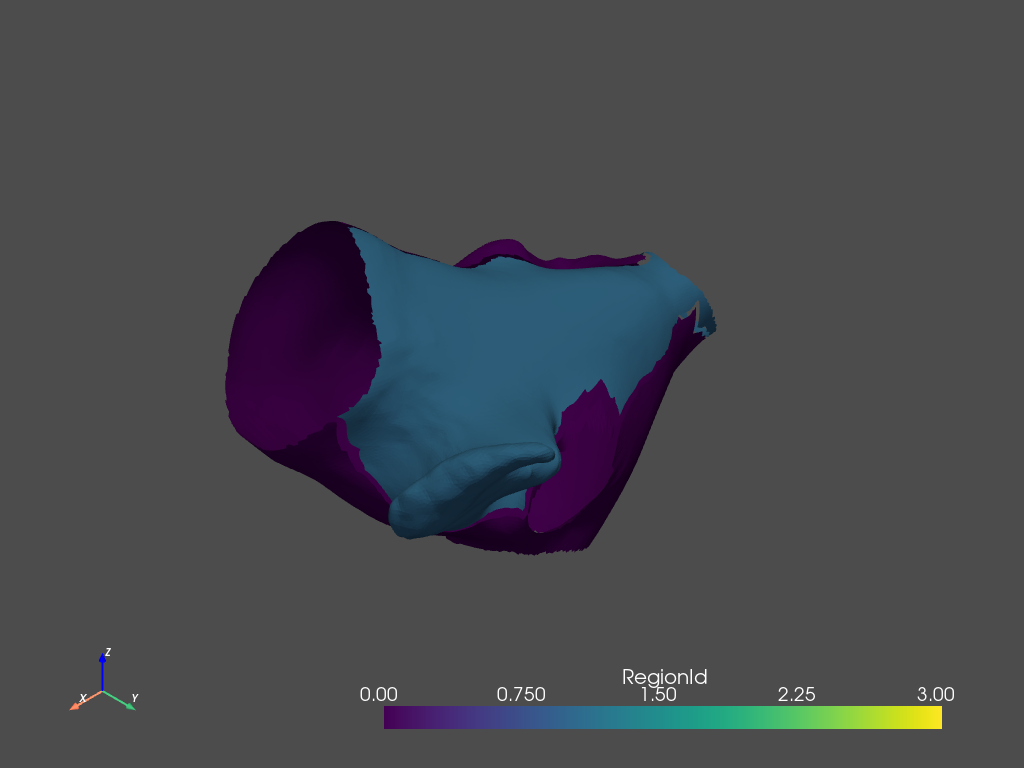

In [40]:
# Split mesh
slicedMesh = clippedMesh.connectivity(largest=False)
slicedMesh.plot(jupyter_backend='static')

In [41]:
# Get rearranged indexes because the connected mesh messes this up
rearrangeInds = np.ones(slicedMesh.n_points,int)

for i in range(slicedMesh.n_points):
    ind = mesh.find_closest_point(slicedMesh.points[i])
    rearrangeInds[i] = ind

In [42]:
#Get Region Ids
slicedRegions = slicedMesh.point_data.get_array('RegionId')

# Put them in a pointData array, rearranged
pointData = np.ones(mesh.n_points)*-1
pointData[rearrangeInds] = slicedRegions

# Interpolate missing points
undefinedPoints = np.where(~np.isin(pointData,[0,1]))[0] # 0 and 1 should ideally be the only labels
definedPoints = np.where(np.isin(pointData,[0,1]))[0]

definedMatrix = mesh.points[definedPoints]

newValues = np.zeros(len(undefinedPoints))
for i,point in enumerate(undefinedPoints):
    point = mesh.points[point]
    dists = np.linalg.norm(definedMatrix-point,axis=1)
    closestInd = np.where(dists==np.min(dists))[0][0]
    newValues[i] = pointData[definedPoints[closestInd]]

pointData[undefinedPoints] = newValues

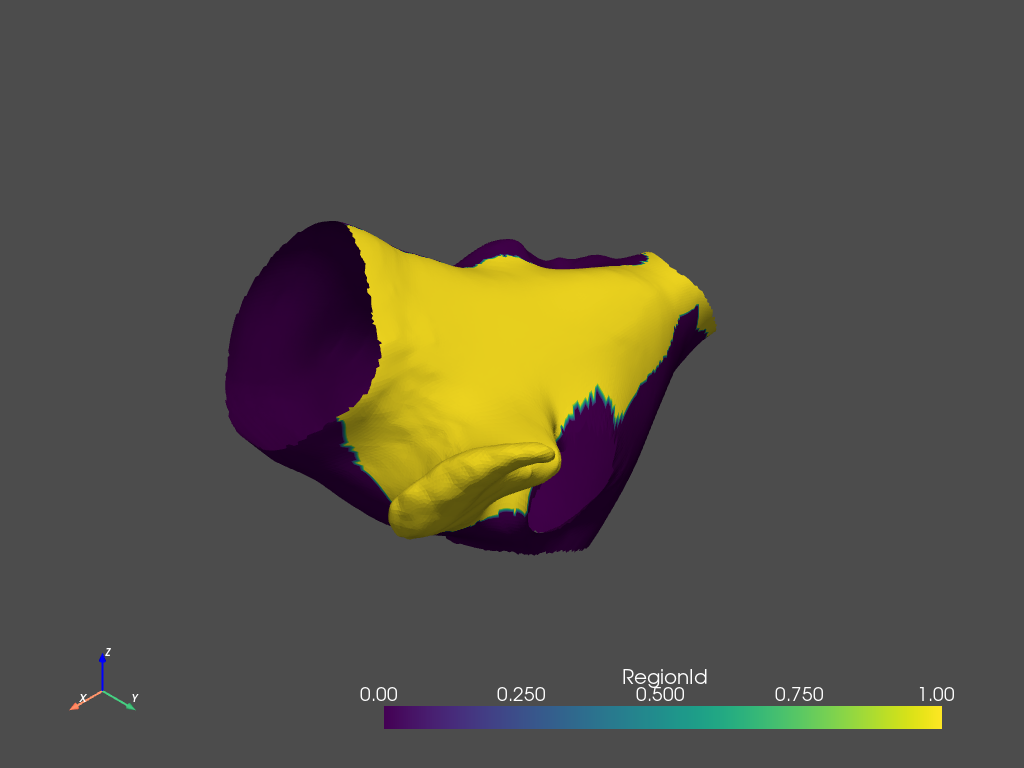

In [43]:
# Add data to mesh
mesh.point_data['RegionId'] = pointData
mesh.plot(scalars='RegionId',jupyter_backend='static')

## Correct coordinates

In this step, it is necessary to mark which portion of the sliced mesh (anterior or posterior) is 0 and 1. Then, the new coordinates are calculated as:

- Posteriorly: $\beta_{LA} = 0.5 \cdot \psi$
- Anteriorly: $\beta_{LA} = 1-0.5 \cdot \psi$

For the Laplacian solution $\psi$

In [44]:
# Input the code of the septal and lateral wall based on the image above
PosteriorCode = int(np.unique(mesh.point_data['RegionId'][ripvIndices])[0])

AnteriorCode = 1-PosteriorCode
print(PosteriorCode)

0


In [45]:
## Load Igbs
alphaFile = os.path.join(carpFolder,'OUTPUT_DIR/%s_alpha.igb'%expName)
betaFile = os.path.join(carpFolder,'OUTPUT_DIR/%s_beta.igb'%expName)

alpha,hdr_a = igb.Load(alphaFile)
beta,hdr_b = igb.Load(betaFile)

mesh.point_data['alpha'] = alpha
mesh.point_data['beta'] = beta

In [46]:
################## Alpha Adjustment

## Get only lateral wall
meshPosterior = deepcopy(mesh)
toRemove = meshPosterior.point_data['RegionId']==AnteriorCode
toRemove[anteroPosteriorBoundary] = False
meshPosterior,ridx = meshPosterior.remove_points(toRemove)

## Select points with beta == 0 to beta == 1
# we get the "mid point" of the region with the extreme beta values

indA = np.where(meshPosterior.point_data['alpha']==0)[0]
indA = indA[np.argsort(meshPosterior.point_data['beta'][indA])]
indA = indA[len(indA)//2]

indB = np.where(meshPosterior.point_data['alpha']==1)[0]
indB = indB[np.argsort(meshPosterior.point_data['beta'][indB])]
indB = indB[len(indB)//2]

## Get the part of the mesh only with similar alpha
aA = meshPosterior.point_data['beta'][indA]
aB = meshPosterior.point_data['beta'][indB]

tol = .2# I don't get why this makes a difference but ok
toRemove = (meshPosterior.point_data['beta']<np.min([aA,aB])-tol) ^ (meshPosterior.point_data['beta']>np.max([aA,aB])+tol) 
meshPosterior,ridx2 = meshPosterior.remove_points(toRemove,mode='any')

indA = np.where(ridx2==indA)[0][0]
indB = np.where(ridx2==indB)[0][0]

## Find the shortest path between the points with beta ==0 and beta ==1
# And get the beta progression
path = calculate_vertex_path(meshPosterior,indA,indB)
alphaPath = meshPosterior.point_data['alpha'][path]

## Calculate the equivalent normalized geodesic distance
pathDistance = [calculate_vertex_distance(meshPosterior,indA,index) for index in path[1:]]
pathDistance = np.hstack([0,pathDistance])
pathDistance = (pathDistance-pathDistance.min())/(pathDistance.max()-pathDistance.min()) # normalize

## Now map the remaining beta values based on the relationship between alphaPath and pathDistance
rescaledAlpha = np.zeros_like(alpha)*np.nan
for index,a in enumerate(mesh.point_data['alpha']):
    if a==1. or a==0.:
        rescaledAlpha[index] = a
        continue
    
    alphaLims = np.array([np.max(alphaPath[alphaPath<a]),np.min(alphaPath[alphaPath>a])])

    neighborInds = [np.where(alphaPath==[alphaLims[0]])[0][-1],np.where(alphaPath==[alphaLims[1]])[0][0]]
    distLims = pathDistance[neighborInds]

    ## The commented section below was giving some problems when all neighbors were 1s or 0s, so I changed to the code above
    # The results are almost the same
    # # find neighbors
    # dists = np.abs(alphaPath-a)

    # # "x"
    # alphaLims = alphaPath[np.argsort(dists)[:3]]
    # # "y"
    # distLims = pathDistance[np.argsort(dists)[:3]]

    #Linear interpolation
    rescaledAlpha[index] = (distLims.max()-distLims.min())*(a-alphaLims.min())/(alphaLims.max()-alphaLims.min())+distLims.min()
    

## Update beta values
mesh.point_data['alpha'] = rescaledAlpha

In [47]:
fig,ax = plt.subplots(1)
ax.plot(alphaPath,label='alpha')
ax.plot(pathDistance,label='normalized distance')
fig.legend(loc=5)
fig.suptitle('Visualization of how much the alpha was rescaled')

Text(0.5, 0.98, 'Visualization of how much the alpha was rescaled')

In [48]:
################## Beta Adjustment

beta[pointData==PosteriorCode] = 0.5*beta[pointData==PosteriorCode]
beta[pointData==AnteriorCode] = 1-0.5*beta[pointData==AnteriorCode]
mesh.point_data['beta'] = beta

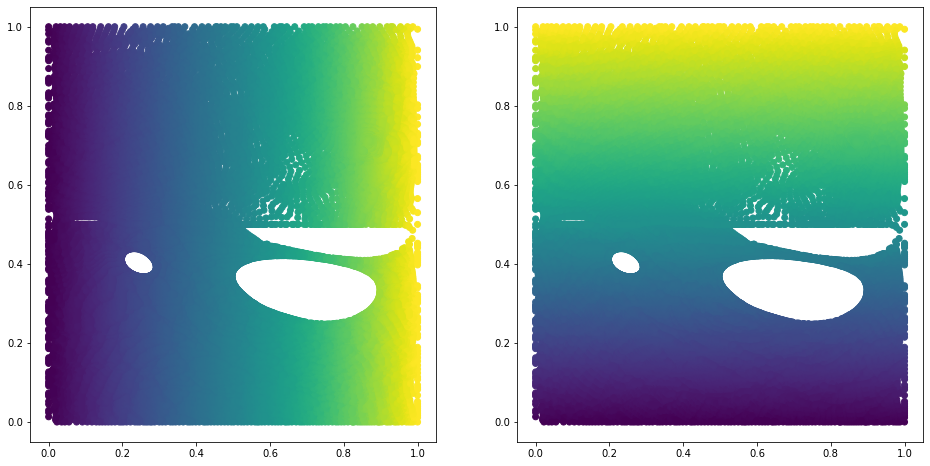

In [49]:
%matplotlib inline
downsample = 1
fig,ax = plt.subplots(1,2,figsize = (16,8))
cax = ax[0].scatter(rescaledAlpha[::downsample],beta[::downsample],c=alpha[::downsample])
ax[1].scatter(rescaledAlpha[::downsample],beta[::downsample],c=beta[::downsample])
# plt.colorbar(cax)

In [50]:
# Write igb
# I cheat here because my function is not working
os.chdir(carpFolder)

file = open(alphaFile,'rb')
hdr_a = file.read(1024)
file.close()

outFile = open('%s_alpha_corrected.igb'%expName,'wb')
outFile.write(hdr_a)
outFile.close()

outFile = open('%s_alpha_corrected.igb'%expName,'ab')
mesh.point_data['alpha'].tofile(outFile)

# Beta
file = open(betaFile,'rb')
hdr_b = file.read(1024)
file.close()

outFile = open('%s_beta_corrected.igb'%expName,'wb')
outFile.write(hdr_b)
outFile.close()

outFile = open('%s_beta_corrected.igb'%expName,'ab')
mesh.point_data['beta'].tofile(outFile)

# os.rename(os.path.join(carpFolder,'OUTPUT_DIR'),os.path.join(carpFolder,expName))

In [51]:
# Save VTK
mesh.save('%s.vtk'%expName)
mesh.save('%s.ply'%expName)
